# Neuralink Time Series Forecasting


## Imports


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io

## Configure Tensorflow


In [2]:
# Identify if the GPU is detected
# tf.config.list_physical_devices()

# Identify if the GPU is being used.
# tf.debugging.set_log_device_placement(False)

## Import Data


In [3]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")

In [4]:
rate, data = scipy.io.wavfile.read(data_file_l[0])

In [5]:
data_df = pd.DataFrame(data, columns=["Amplitude"])

In [6]:
time = np.arange(0, len(data_df) / rate, (1 / rate))

In [7]:
time

array([0.00000000e+00, 5.12006554e-05, 1.02401311e-04, ...,
       5.05329988e+00, 5.05335108e+00, 5.05340228e+00])

In [8]:
data_df.insert(loc=1, column="Time", value=time, allow_duplicates=True)

In [9]:
data_df = data_df.reindex(columns=["Time", "Amplitude"])

In [10]:
data_df.index.name = "Sample Number"

<Axes: title={'center': 'Raw Neural Signal'}, xlabel='Time [s]'>

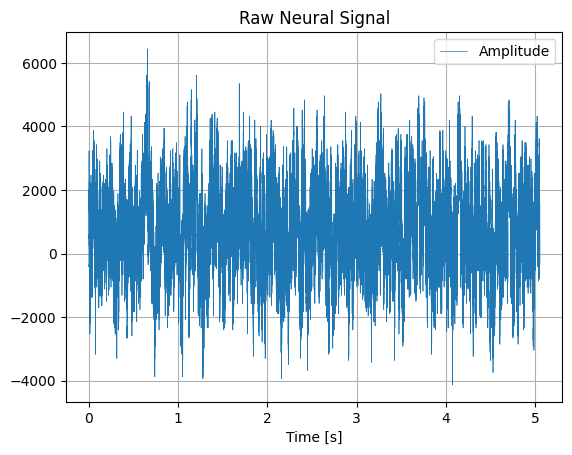

In [11]:
data_df.plot(
    xlabel="Time [s]", x="Time", grid=True, linewidth=0.5, title="Raw Neural Signal"
)

In [12]:
data_df.__len__()

98699

In [13]:
df = data_df.drop("Time", axis=1)

In [14]:
n = df.__len__()

## Defining Training, Validation, & Test Sets


In [15]:
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_15410/2004759091.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


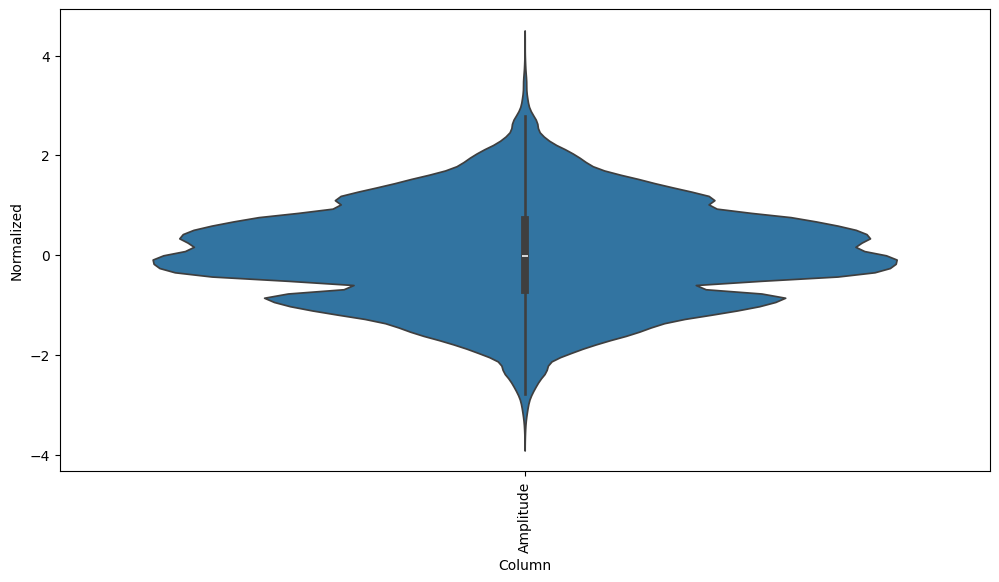

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [18]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        def __repr__(self):
            return "\n".join(
                [
                    f"Total window size: {self.total_window_size}",
                    f"Input indices: {self.input_indices}",
                    f"Label indices: {self.label_indices}",
                    f"Label column name(s): {self.label_columns}",
                ]
            )

In [19]:
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=["Amplitude"]
)

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["Amplitude"])

In [21]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


2024-09-03 14:49:13.946588: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-03 14:49:13.946611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-03 14:49:13.946616: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-03 14:49:13.946629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-03 14:49:13.946642: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col="Amplitude", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot

In [25]:
w2.label_columns_indices

{'Amplitude': 0}

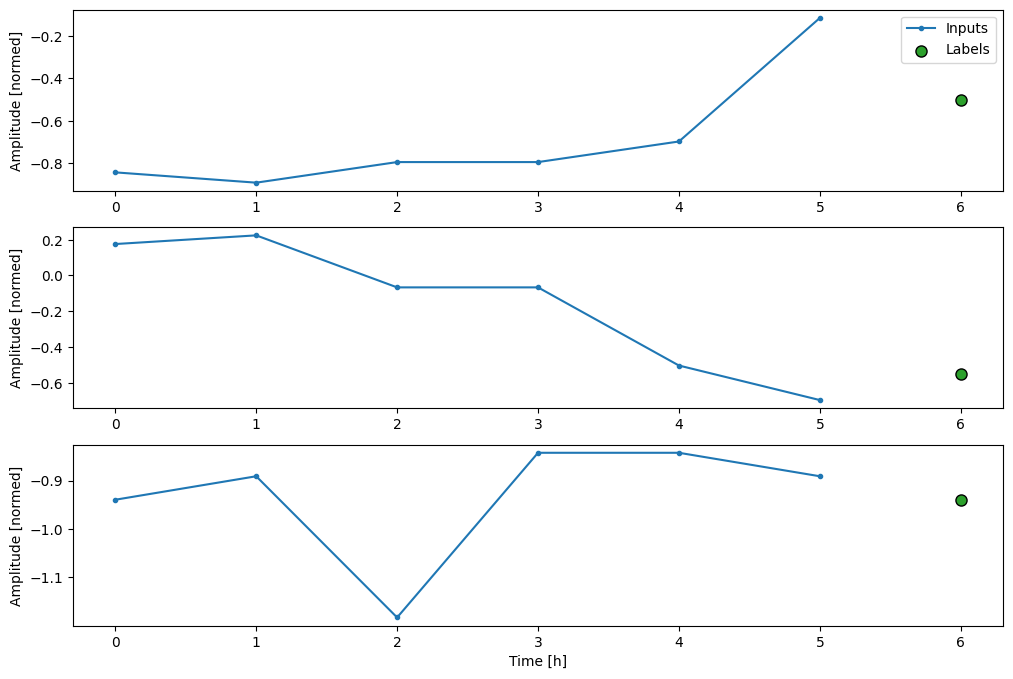

In [26]:
w2.plot()

In [32]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )
    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """get and cache an example batch of `inputs, labels` for ploting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [34]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-03 15:34:45.407574: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Single Step Model


In [36]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["Amplitude"]
)
single_step_window

In [37]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-03 15:51:54.181845: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Baseline


In [38]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [39]:
w1.column_indices

{'Amplitude': 0}